## Assignment 5 - Kmeans


In [1]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from kneed import KneeLocator
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


---

- Loading Dataset and preprocessing


In [2]:
raw_data = pd.read_csv('./Mall_Customers.csv')
raw_data = raw_data.drop(columns=['CustomerID'])  # removing irrelevant column
raw_data['Genre'] = np.where(raw_data['Genre'] == 'Male', 1, 0)


---

- Fitting estimator to the data


In [3]:
# creating KMeans estimator class and setting the algorithm parameters
kmeans_kwargs = {
    "init": "random",  # set the algorithm parameters
    "n_init": 10,  # sets the number of initializations to perform, default is 10, one with lowest SSE is choosen
    "max_iter": 300,  # number of maximum iterations for each initialization
    "random_state": 42
}

# SSE - The SSE is defined as the sum of the squared Euclidean distances of each point to its closest centroid. Since this is a measure of error, the objective of k-means is to try to minimize this value.

# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    # dictionary unpacking operator(**)
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(raw_data)
    sse.append(kmeans.inertia_)


---

- Evaluating the SSE scores for different K values


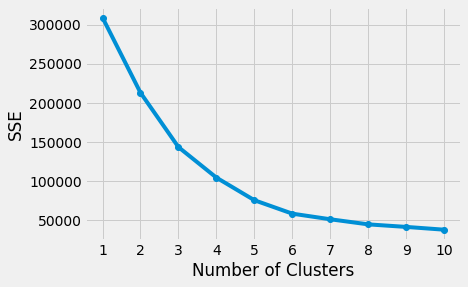

In [4]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse, '-o')
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()
# SSE continues to decrease as you increase k. As more centroids are added, the distance from each point to its closest centroid will decrease
# sweet spot where the SSE curve starts to bend known as the elbow point. The x-value(K) of this point is thought to be a reasonable trade-off between error and number of clusters


---

- Identifying the elbow point programmatically from SSE curve


In [5]:
kl = KneeLocator(
    range(1, 11), sse, curve="convex", direction="decreasing"
)

kl.elbow
# Gives elbow point as 4, i.e. after increasing the value of K does not affect the inertial value hench choosing K=4


4

---

- Evaluating the Silhouette Coefficients for K values


In [6]:
# Silhouette Score = (b-a)/max(a,b)
# where, a = average intra-cluster distance i.e the average distance between each point within a cluster
# b = average inter-cluster distance i.e the average distance between all clusters

# A list holds the silhouette coefficients for each k
silhouette_coefficients = []

# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(raw_data)
    # needs minimum of two clusters and return average of silhouette score for each cluster
    score = silhouette_score(raw_data, kmeans.labels_,
                             metric='euclidean', random_state=42)
    silhouette_coefficients.append(score)
    # Silhouette coefficient values range between -1 and 1. Larger numbers indicate that samples are closer to their clusters than they are to other clusters.


---

- plotting the the score (average Silhouette score for each K values)


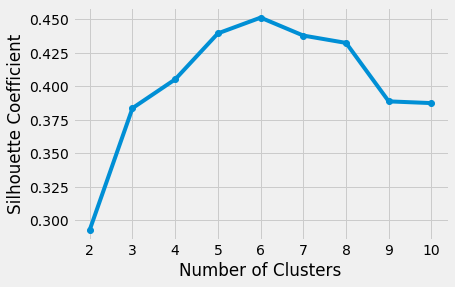

In [7]:
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients, '-o')
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()
# Shows maximum value of Silhouette coefficient at K=6


---

- Using K=4+6/2=5 as the final number of clusters and fitting the data


In [8]:
kmeans = KMeans(n_clusters=5, **kmeans_kwargs)
kmeans.fit(raw_data)
raw_data['Labels'] = kmeans.labels_ # assigning new column for Labels of identified clusters

# only considering centers of 3rd and 4th columns to be plotted on the graph
centers_x, centers_y = kmeans.cluster_centers_[:, 2], kmeans.cluster_centers_[:, 3]

# Counting number of customers in each cluster
keys = list(Counter(raw_data['Labels'])) # keys(indices of label) in unsorted order
values_temp = list(Counter(raw_data['Labels']).values()) # values(count of that label) in sorted order
values = {} # new dictionary of (label: count)
for index, value in enumerate(values_temp):
    values[keys[index]] = values_temp[index]
values = dict(sorted(values.items())) # dictionary with sorted keys(indices of labels)

---
* Plotting the results

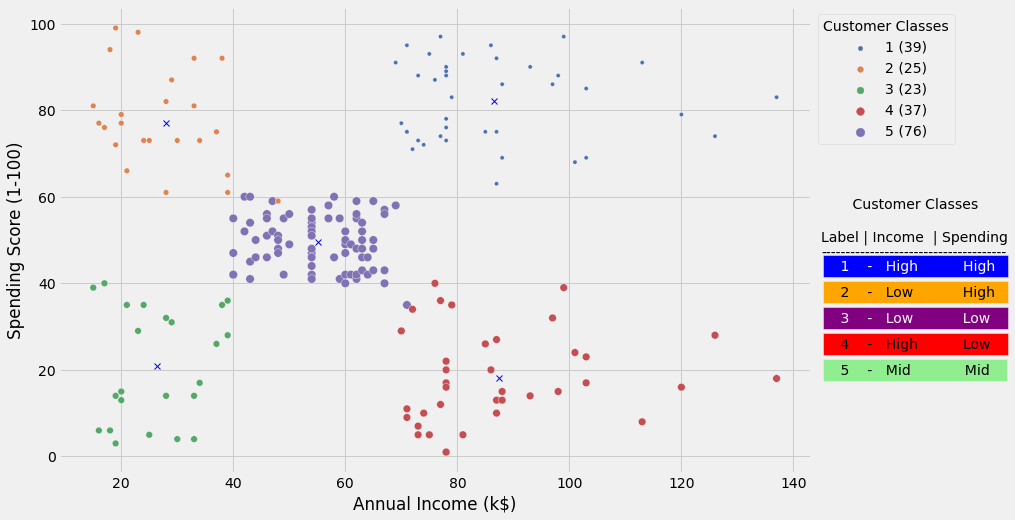

In [9]:
plt.figure(figsize=(12, 8))
plt.plot(centers_x, centers_y, 'xb')  # Plotting the centers on the graph
ax = sns.scatterplot(data=raw_data, x='Annual Income (k$)', y='Spending Score (1-100)',
                     hue=raw_data['Labels'], palette='deep', size='Labels')

legend_labels, _ = ax.get_legend_handles_labels()
labels = []
for index, value in enumerate(values):
    labels.append(str(index + 1) + ' (' + str(values[index]) + ')')
ax.legend(legend_labels, labels, bbox_to_anchor=(1, 1), title='Customer Classes')
plt.text(145, 46, '       Customer Classes\n\nLabel | Income  | Spending\n--------------------------------------')
plt.text(146, 43, '   1    -   High          High  ', color='white', bbox=dict(facecolor='blue'))
plt.text(146, 37, '   2    -   Low           High  ', color='black', bbox=dict(facecolor='orange'))
plt.text(146, 31, '   3    -   Low           Low   ', color='white', bbox=dict(facecolor='purple'))
plt.text(146, 25, '   4    -   High          Low   ', bbox=dict(facecolor='red'))
plt.text(146, 19, '   5    -   Mid            Mid   ', bbox=dict(facecolor='lightgreen'))
plt.show()
